In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_poisson_deviance

In [3]:
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast

def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.

    Parameters
        shape - an int, or a tuple of ints

    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions

    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.

    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)


    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
#     dim = filter(lambda i : i != 1,dim)
    return strided.reshape(dim)

In [4]:
from sklearn.decomposition import PCA

def apply_extraction(x):
    pca = PCA(n_components=1).fit_transform(x)
    return np.hstack([
    #return np.concatenate([
        x[0],
        x[-1],
        np.mean(x, axis=0),
        np.median(x, axis=0),
        np.var(x, axis=0),
        np.std(x, axis=0),
        np.max(x, axis=0),
        np.min(x, axis=0),
        np.argmax(x, axis=0),
        np.argmin(x, axis=0),
        np.sum(x, axis=0),
        np.quantile(x, q=.5, axis=0),
        np.quantile(x, q=.75, axis=0),
        np.quantile(x, q=.25, axis=0),
        #spectral_centroid(y=x, sr=40, hop_length=x.shape[0]+1),
        np.min([pca]),
        np.max([pca]),
        np.mean([pca]),
        np.array([pca]).flatten()
    ])

In [5]:

def apply_sliding_window(X, y, ws=400, ss=80): # maybe use bigger windows to reduce the number of samples?
    
    data_x = sliding_window(X,(ws,X.shape[1]),(ss,1))
    
    data_x = np.array([ apply_extraction(x) for x in data_x])
    
    data_y = np.asarray([[i[-1]] for i in sliding_window(y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y))

In [6]:
from collections import namedtuple

def df_to_dataset(df):
    data = df.drop(['timestamp', 'tac_clean', 'tac_raw', 'ir_voltage', 'temperature'], axis='columns')
    target = df['tac_clean']
    
    data, target = apply_sliding_window(data.to_numpy(), target.to_numpy())
    
    dataset = namedtuple('Dataset', ['data', 'target'])
    dataset.data = data
    dataset.target = target

    return dataset   

---

## Return all test data

In [7]:
data_path = os.path.join('..','data','interim','no_gaps_resampled')

In [11]:
def splitn_predict(model):
    test_vals = []
    test_preds = []
    print(model)
    for file in os.listdir(data_path):
        df = pd.read_feather(os.path.join(data_path, file))
        dataset = df_to_dataset(df)
        X_train, X_val, y_train, y_val = train_test_split(dataset.data, dataset.target, random_state=42)
        y_pred = model.predict(X_val)
        test_vals.append(y_val)
        test_preds.append(y_pred)
    return (np.concatenate(test_vals), np.concatenate(test_preds))


In [12]:
models_path = os.path.join('..','models')
model_results = {}

In [13]:
for mod in os.listdir(models_path):
    if 'git' in mod:
        continue
    name = mod.replace('.pickle','')
    print(f'Testing for {name}')
    
    with open (os.path.join(models_path, mod),'rb') as op:
        model = pickle.load(op)
        y_val, y_pred = splitn_predict(model)
        model_results.setdefault(name, (y_val, y_pred))


Testing for ETS
ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=110, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)
Testing for HGB
HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_absolute_deviation', max_bins=255,
                              max_depth=None, max_iter=85, max_leaf_nodes=2,
                              min_samples_leaf=24, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=Fal

In [37]:
err_metrics = [
    'mean_squared_error',
    'explained_variance_score',
    'max_error',
    #'mean_squared_log_error',
    'median_absolute_error',
    'r2_score',
    #'mean_poisson_deviance',
    #'mean_gamma_deviance',
    #'mean_tweedie_deviance',
    #'mean_poisson_deviance'
]
def apply_err_metrics(y_v, y_p):
    return np.hstack([
        mean_squared_error(y_v, y_p),
        explained_variance_score(y_v, y_p),
        max_error(y_v, y_p),
        #mean_squared_log_error(y_v, y_p),
        median_absolute_error(y_v, y_p),
        r2_score(y_v, y_p),
        #mean_poisson_deviance(y_v, y_p),
        #mean_gamma_deviance(y_v, y_p),
        #mean_tweedie_deviance(y_v, y_p),
        #mean_poisson_deviance(y_v, y_p)
    ])        

In [39]:
for method, (y_val, y_pred) in model_results.items():
    err_stack = apply_err_metrics(y_val, y_pred)
    print(method)
    for i,st in enumerate(err_stack):
        print(f'{err_metrics[i]}: {st}')
        #fig, ax = plt.subplots(figsize=(15,10))
        #ax.plot(y_val,label="Values")
        #ax.plot(y_predict,label="Predictions")
        #plt.title(method+'_'+err_metrics[i],size=25)
        #ax.legend()
    print('\n')

ETS
mean_squared_error: 0.0058061219972380075
explained_variance_score: -0.021142258997227215
max_error: 0.13920347746654133
median_absolute_error: 0.0656590988660579
r2_score: -0.8174029194795858


HGB
mean_squared_error: 0.0065370572623868525
explained_variance_score: -0.028046108227763655
max_error: 0.16630639126492403
median_absolute_error: 0.0714812591669979
r2_score: -1.0461965764960977


LGB
mean_squared_error: 0.0066597259377042615
explained_variance_score: -0.027706331514530058
max_error: 0.14586558133612537
median_absolute_error: 0.07211105736698306
r2_score: -1.0845937043478036


XGB
mean_squared_error: 0.009520274940766137
explained_variance_score: -0.12871985342439185
max_error: 0.18388050459256414
median_absolute_error: 0.09304190550847147
r2_score: -1.9799882744157675




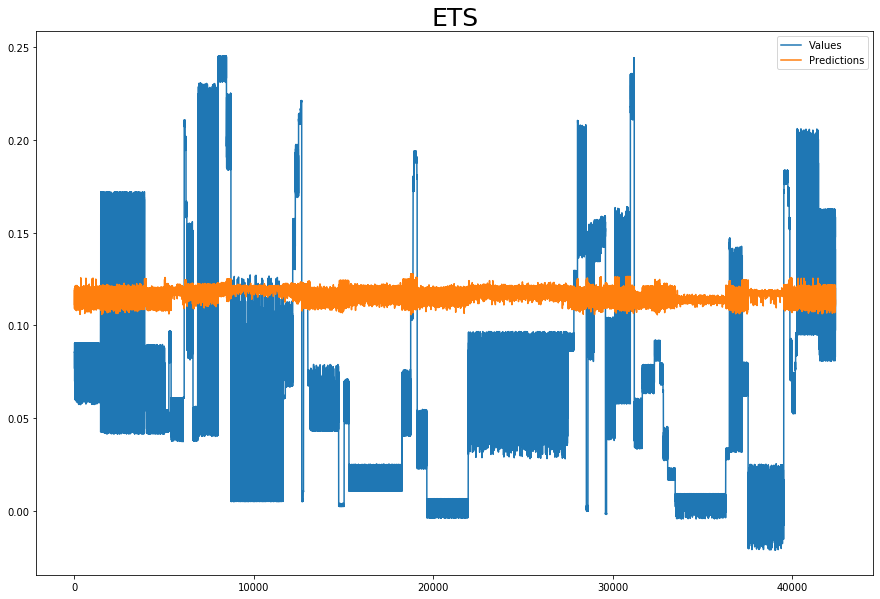

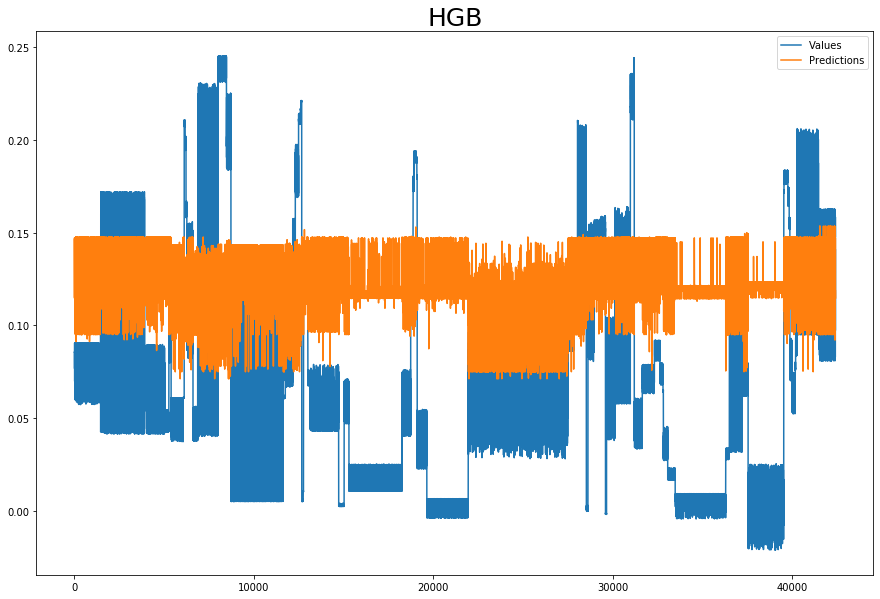

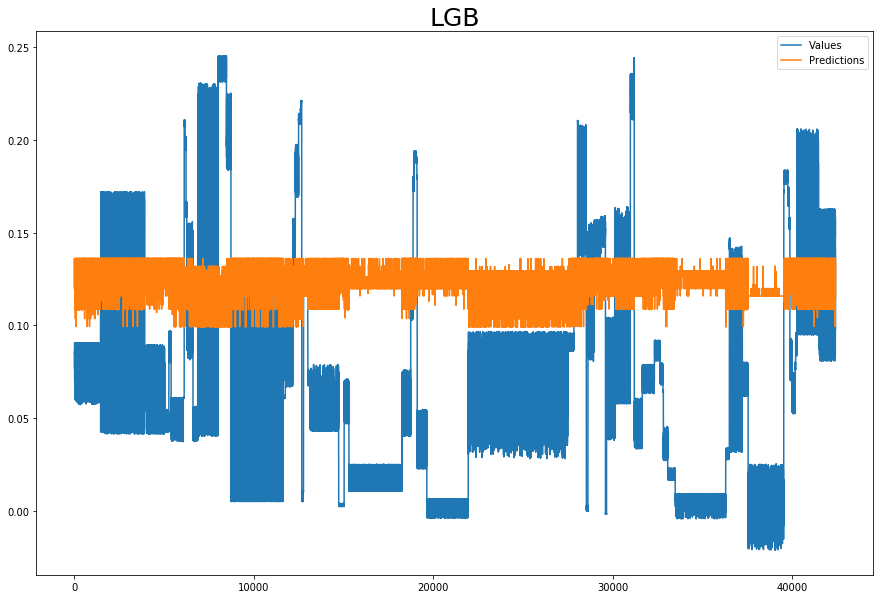

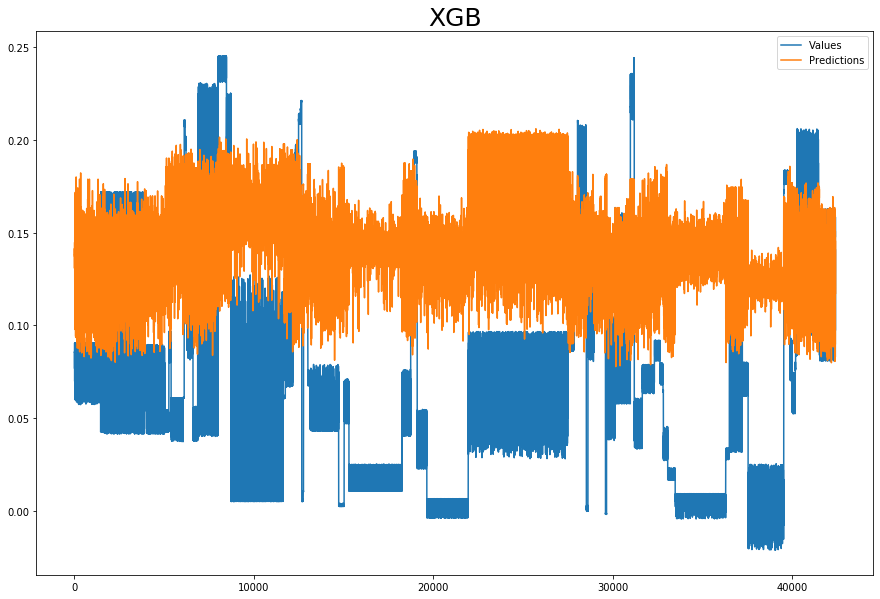

In [40]:
for method, (y_val, y_pred) in model_results.items():
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(y_val,label="Values")
    ax.plot(y_pred,label="Predictions")
    plt.title(method,size=25)
    ax.legend()